In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import random
import os
import warnings
import matplotlib.pyplot as plt # 득점모델 변수 중요도
import seaborn as sns

warnings.filterwarnings("ignore")

def visual_df(train):
    feature_selection = [f for f in train.columns if train[f].isnull().sum()<30000 and f != 'customer_country.1']
    train = train[feature_selection]
    feature_summary = pd.DataFrame(train.dtypes, columns=["Data Type"])
    feature_summary.reset_index(inplace=True)
    feature_summary.rename(columns={'index': 'Feature 이름'}, inplace=True)
    feature_summary['고유값 수'] = train.nunique().values
    feature_summary['결측값 수'] = train.isnull().sum().values
    return feature_summary
    

def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
seed_everything()

def get_clf_eval(y_test, y_pred=None):

    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

def log_transform(data,cols):
    for col in cols :
        data[col]=np.log1p(data[col]) 
    return data 

def label_encoding(series):
    # """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}
    # 모든 요소를 문자열로 변환
    mode = np.flip(series.value_counts().index.values)
    # unique value 찾고 아스키코드 기준으로 sort
    # my_dict을 통해 unique value에 대응하는 label 생성 
    for idx, value in enumerate(mode):
        my_dict[value] = idx
    # my_dict의 index와 매치되는 series값을 my_dict의 value로 변환한다.
    series = series.map(my_dict)

    return series

def same_word_detect(df, categorical_list):
    for feature in categorical_list:
        df[feature] = df[feature].str.lower()
        # 특수문자를 대체 문자열 지정
        replacement = {'/': '', 
                       '-':'', 
                       '_':'', 
                       ' ':'', 
                       '~':'',
                       '&':'',
                       '.':'',
                       ',':''}
        # replace() 함수를 사용하여 특수 문자 대체
        df[feature].replace(replacement, inplace=True)
    return df

def preprocessing(train, test):

    label_columns = [feature for feature in train.columns if train[feature].dtype=='O' and feature == 'customer_idx' and feature == 'lead_owner' ]
    

    df_all = pd.concat([train[label_columns], test[label_columns]])
    df_all = df_all.astype(str)
    df_all = same_word_detect(df_all, label_columns)
    temp = df_all
 
    
    # label encoding
    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    # test set 분리 
    for col in label_columns:  
        train[col] = df_all.iloc[: len(train)][col]
        test[col] = df_all.iloc[len(train) :][col]
    
    return train, test

def model_train(train, test, model):

    train, test = preprocessing(train, test)
    x_train, x_val, y_train, y_val = train_test_split(
    train.drop("is_converted", axis=1),
    train["is_converted"],
    test_size=0.2,
    stratify=train["is_converted"],
    shuffle=True,
    random_state=42,)
    
    model = model
    model.fit(x_train.fillna(0), y_train)
    pred = model.predict(x_val.fillna(0))
    metrics = get_clf_eval(y_val, pred)
    print(f'validaion에서 true: {sum(pred)}')
    print(metrics)

    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
    ftr_top = ftr_importances.sort_values(ascending=False)[:20]
    print(ftr_top[:5])
    plt.figure(figsize=(8, 6))
    sns.barplot(x=ftr_top, y=ftr_top.index)
    plt.show()
    return model, metrics

오차행렬:
 [[  781   189]
 [  202 10688]]

정확도: 0.9670
정밀도: 0.7945
재현율: 0.8052
F1: 0.7998
validaion에서 true: 983
None
customer_idx          0.621568
lead_owner            0.095860
response_corporate    0.059623
lead_desc_length      0.051998
customer_country      0.050059
dtype: float64


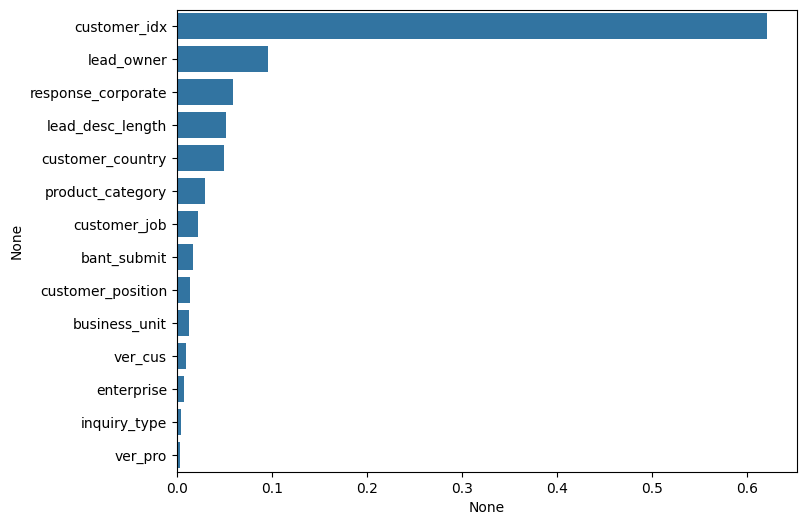

In [24]:
train = pd.read_csv('/home/workspace/LGamiers/EDA/train.csv')
test = pd.read_csv("/home/workspace/LGamiers/Model/submission.csv")
feature_selection = [f for f in train.columns if train[f].isnull().sum()<30000 and f != 'customer_country.1']
train = train[feature_selection]
test = test[feature_selection]
# log 변환
# columns_to_log=['lead_desc_length']
# train,test= log_transform(train,columns_to_log ),log_transform(test,columns_to_log)
train, test = preprocessing(train, test)
model = DecisionTreeClassifier()
model, metrics = model_train(train, test, model)
# 예측에 필요한 데이터 분리
x_test = test.drop(["is_converted"], axis=1)
test_pred = model.predict(x_test.fillna(0))


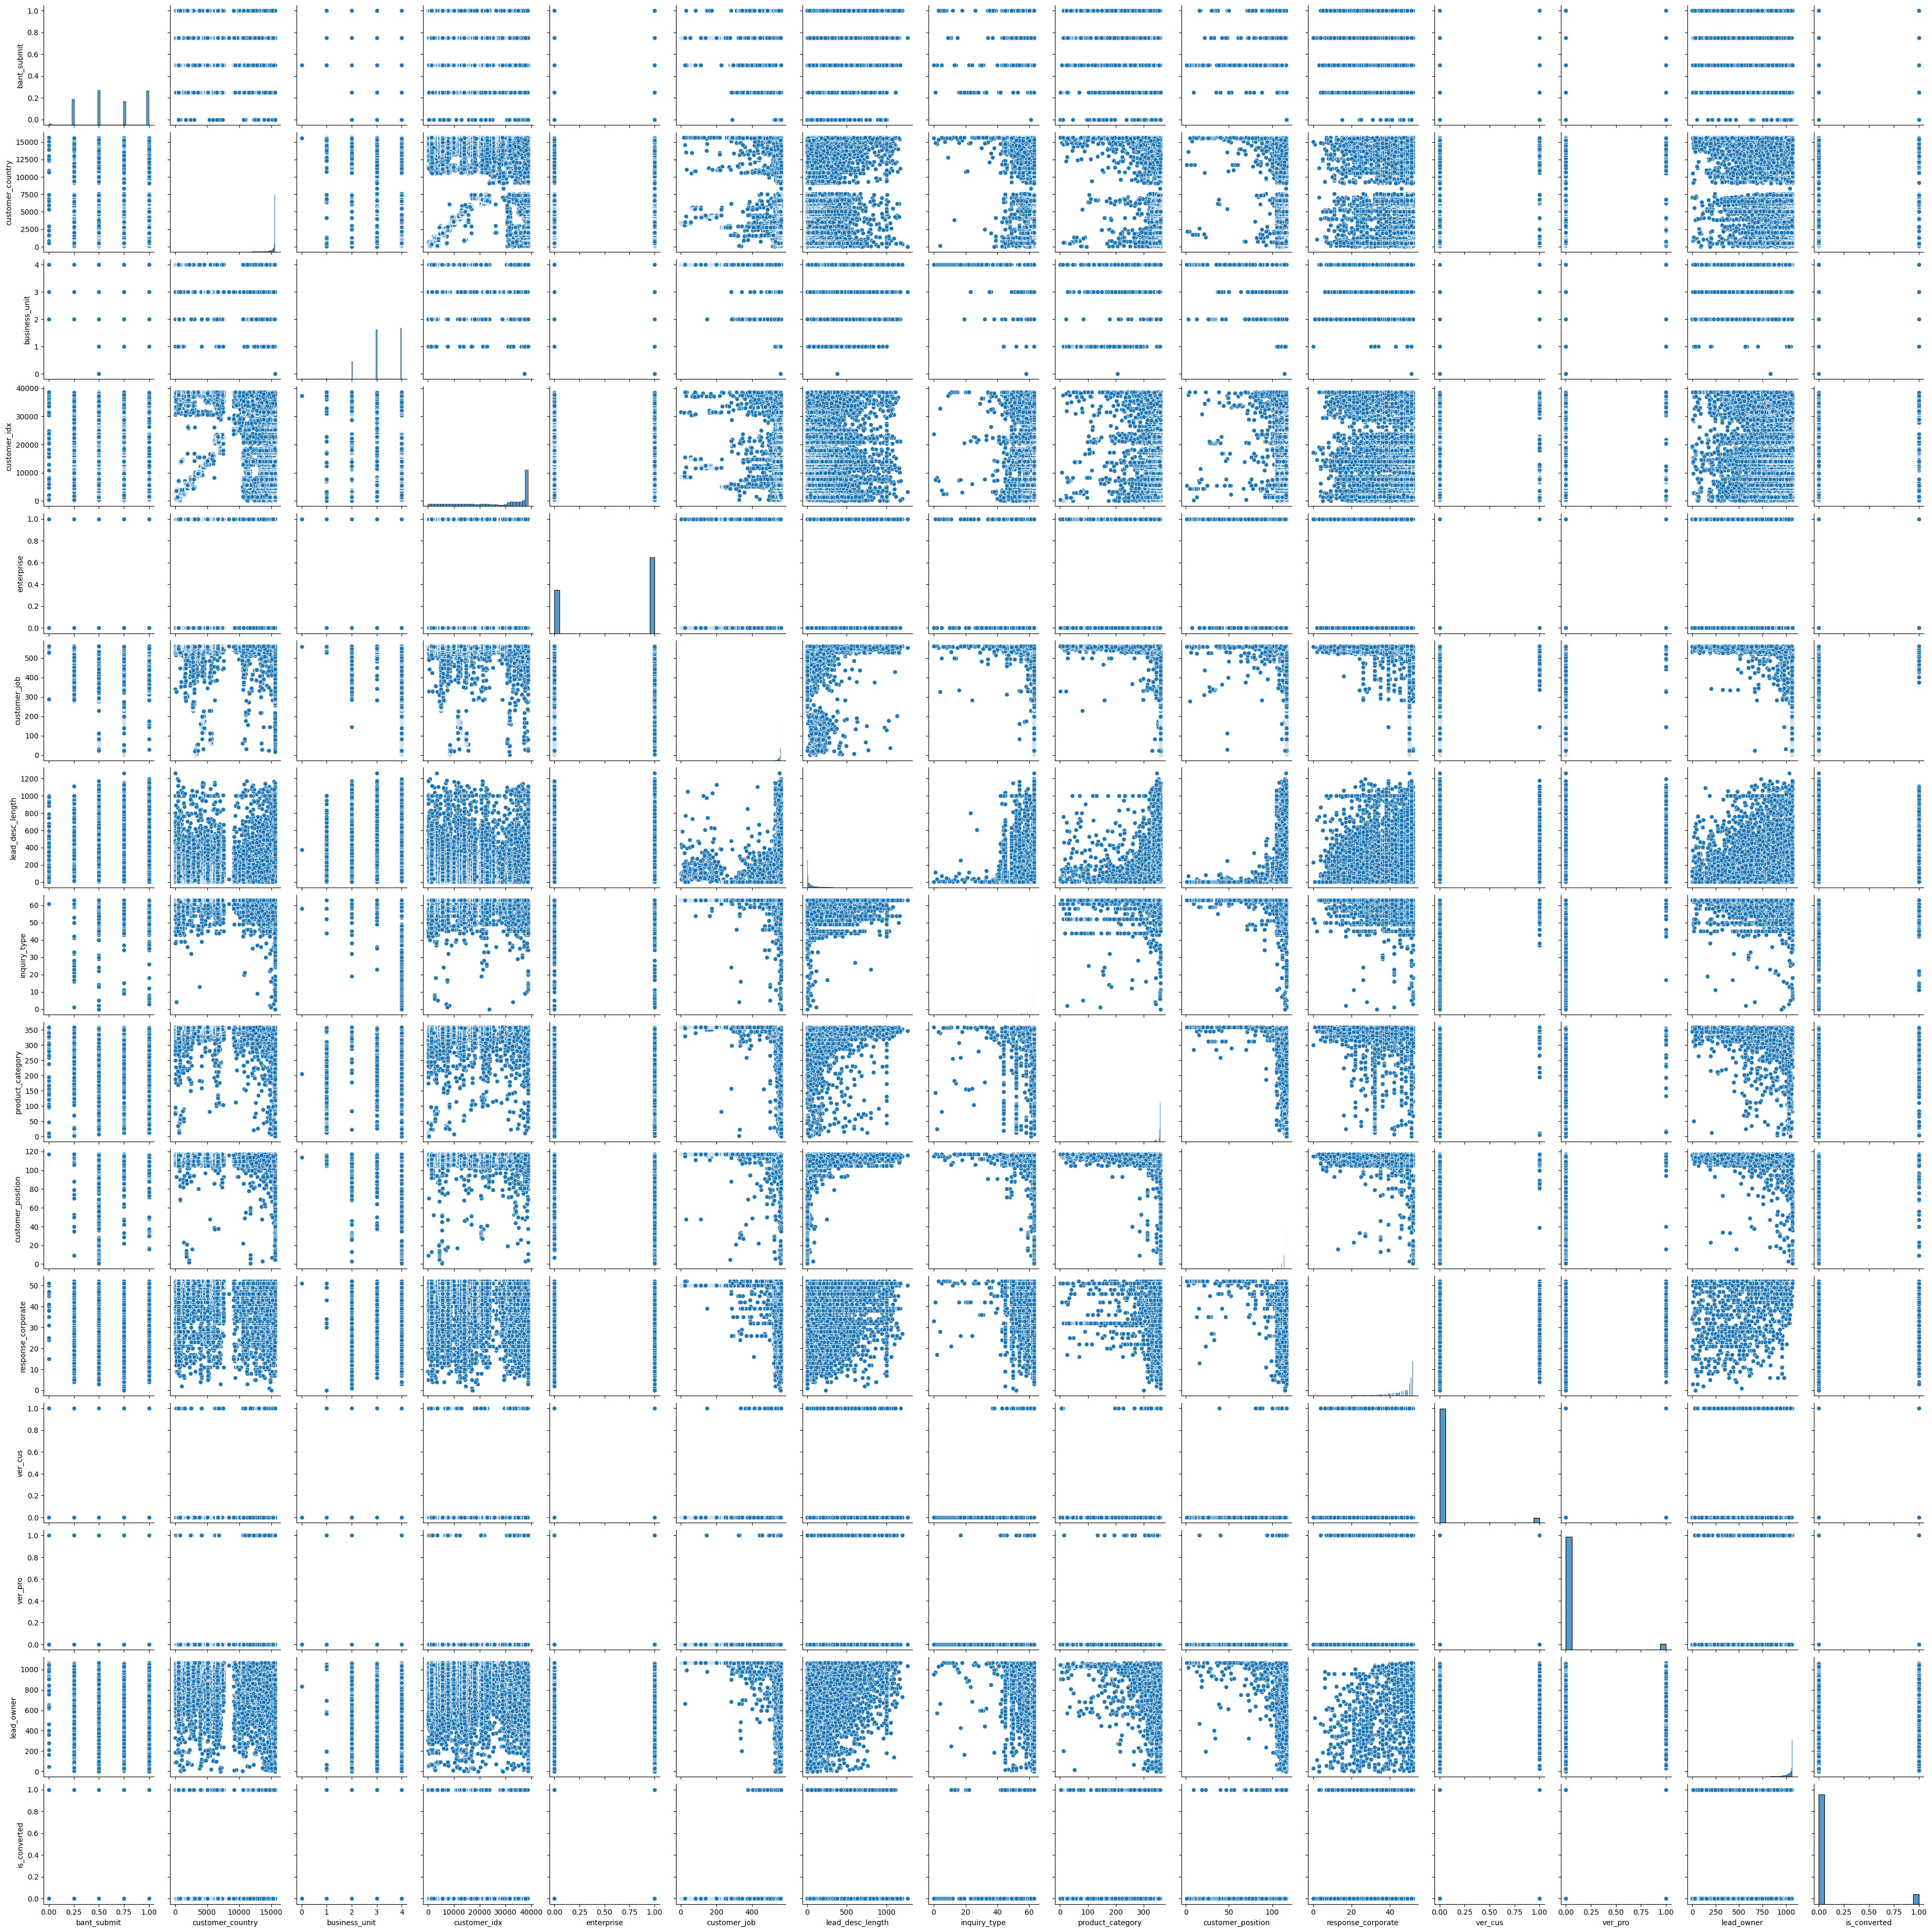

In [4]:
train = pd.read_csv('/home/workspace/LGamiers/EDA/train.csv')
test = pd.read_csv("/home/workspace/LGamiers/Model/submission.csv")
feature_selection = [f for f in train.columns if train[f].isnull().sum()<30000 and f != 'customer_country.1']
train = train[feature_selection]
test = test[feature_selection]
train, test = preprocessing(train, test)
sns.pairplot(data= train)

오차행렬:
 [[  789   181]
 [  182 10708]]

정확도: 0.9694
정밀도: 0.8126
재현율: 0.8134
F1: 0.8130
validaion에서 true: 971
None
customer_idx          0.620569
lead_owner            0.095660
response_corporate    0.059849
lead_desc_length      0.051714
customer_country      0.051173
dtype: float64


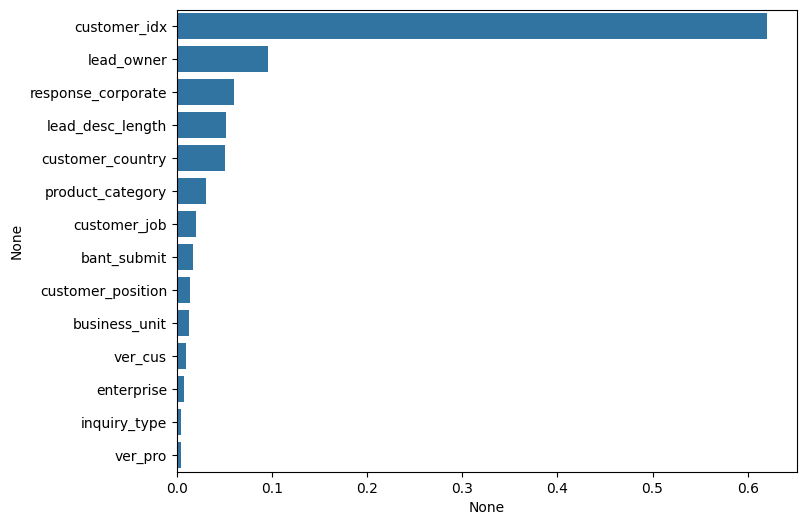

550


In [31]:

train = pd.read_csv('/home/workspace/LGamiers/EDA/train.csv')
test = pd.read_csv("/home/workspace/LGamiers/Model/submission.csv")
feature_selection = [f for f in train.columns if train[f].isnull().sum()<30000 and f != 'customer_country.1']
train = train[feature_selection]
test = test[feature_selection]

train, test = preprocessing(train, test)

# log 변환
columns_to_log=['customer_idx']
train, test= log_transform(train,columns_to_log ),log_transform(test,columns_to_log)

model = DecisionTreeClassifier()
model, metrics = model_train(train, test, model)
# 예측에 필요한 데이터 분리
x_test = test.drop(["is_converted"], axis=1)
test_pred = model.predict(x_test.fillna(0))
print(sum(test_pred))


In [27]:
sum(test_pred) # True로 예측된 개수

689

오차행렬:
 [[  791   179]
 [  204 10686]]

정확도: 0.9677
정밀도: 0.7950
재현율: 0.8155
F1: 0.8051
validaion에서 true: 995
None
customer_idx          0.620533
lead_owner            0.092400
response_corporate    0.060880
customer_country      0.054577
lead_desc_length      0.052161
dtype: float64


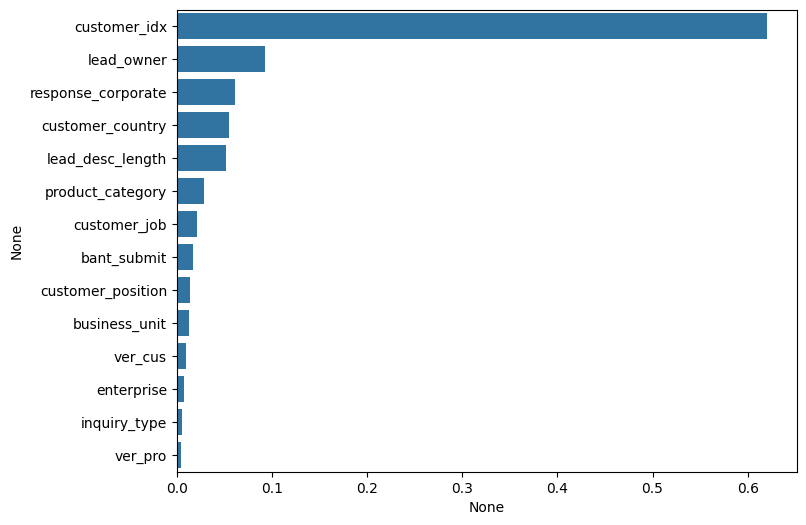

In [29]:
train = pd.read_csv('/home/workspace/LGamiers/EDA/train.csv')
test = pd.read_csv("/home/workspace/LGamiers/Model/submission.csv")
feature_selection = [f for f in train.columns if train[f].isnull().sum()<30000 and f != 'customer_country.1']
train = train[feature_selection]
test = test[feature_selection]

train, test = preprocessing(train, test)

# log 변환
# columns_to_log=['customer_idx']
# train, test= log_transform(train,columns_to_log ),log_transform(test,columns_to_log)

model = DecisionTreeClassifier()
model, metrics = model_train(train, test, model)
# 예측에 필요한 데이터 분리
x_test = test.drop(["is_converted"], axis=1)
test_pred = model.predict(x_test.fillna(0))


In [30]:
sum(test_pred) # True로 예측된 개수

667

In [5]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import (accuracy_score,confusion_matrix,f1_score,precision_score, recall_score,roc_auc_score)

def SkfoldCV(x,y,zero_wei,one_wei,seed) :
    
    real_preds = []
    class_weight={0:zero_wei , 1:one_wei}
    model = RandomForestClassifier(random_state=seed ,class_weight =class_weight)
    Skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  
    cv_precision_scores, cv_recall_scores, cv_confusion_matrices, cv_f1_scores, cv_roc_auc_scores, cv_TN = [],[],[],[],[],[] 
    for train_index, test_index in Skfold.split(x, y):  
        x_train, x_test, y_train, y_test= x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        test_pred = model.predict(test)
        real_preds.append(test_pred)
        
        pred_proba = model.predict_proba(x_test)[:, 1]  
        
        f1 = np.round(f1_score(y_test, pred, average='binary'), 4)  
        precision = np.round(precision_score(y_test, pred, average='binary'), 4)  
        recall = np.round(recall_score(y_test, pred, average='binary'), 4)  
        conf_matrix = confusion_matrix(y_test, pred)  
        roc_auc = roc_auc_score(y_test, pred_proba)  
        
        TN = conf_matrix[1][1]  # TN 값 저장
        cv_TN.append(TN)  # TN 값 저장

        cv_f1_scores.append(f1)  
        cv_precision_scores.append(precision)  
        cv_recall_scores.append(recall)  
        cv_confusion_matrices.append(conf_matrix)  
        cv_roc_auc_scores.append(roc_auc)  
        
    average_conf_matrix = np.mean(np.array(cv_confusion_matrices), axis=0)
    print(f"> F1 Score: {np.mean(cv_f1_scores)}, 정밀도: {np.mean(cv_precision_scores)}, 재현율: {np.mean(cv_recall_scores)}, ROC-AUC: {np.mean(cv_roc_auc_scores)}")
    print('> 평균 검증 오차행렬: \n', average_conf_matrix)  
    
    return real_preds, np.mean(cv_f1_scores), np.mean(cv_roc_auc_scores), np.mean(cv_TN)  # TN 평균 값 리턴



In [17]:
train = pd.read_csv('/home/workspace/LGamiers/EDA/train.csv')
test = pd.read_csv("/home/workspace/LGamiers/Model/submission.csv")
feature_selection = [f for f in train.columns if train[f].isnull().sum()<30000 and f != 'customer_country.1']
train = train[feature_selection]
test = test[feature_selection].drop('is_converted', axis=1)
train, test = preprocessing(train, test)
x = train.drop('is_converted', axis=1)
y = train.is_converted

preds,_,_,TN = SkfoldCV(x,y,1,3,3)
print("Average TN:", TN)
preds

> F1 Score: 0.8422599999999999, 정밀도: 0.96649, 재현율: 0.7466, ROC-AUC: 0.9860335717991575
> 평균 검증 오차행렬: 
 [[5432.3   12.6]
 [ 122.9  362.1]]
Average TN: 362.1


[array([False,  True, False, ..., False, False, False]),
 array([False,  True, False, ..., False, False, False]),
 array([False,  True, False, ..., False, False, False]),
 array([False,  True, False, ..., False, False, False]),
 array([False,  True, False, ..., False, False, False]),
 array([False,  True, False, ..., False, False, False]),
 array([False,  True, False, ..., False, False, False]),
 array([False,  True, False, ..., False, False, False]),
 array([False,  True, False, ..., False, False, False]),
 array([False,  True, False, ..., False, False, False])]

In [19]:
predictions = np.array(preds)
predictions
# 예측값들의 평균을 계산하여 최종 예측값 도출
final_prediction = np.mean(predictions, axis=0)

# 0.2 미만은 0으로, 0.2 이상은 1로 변환
final_prediction = np.where(final_prediction < 0.2, 0, 1)

count_0 = np.size(np.where(final_prediction == 0))
count_2 = np.size(np.where(final_prediction >0))
count_1 = np.size(np.where(final_prediction == 1))

# 각 값을 출력
print("Count of 0:", count_0)
print("Count of 1:", count_1)
len(final_prediction)

Count of 0: 5065
Count of 1: 206


5271

In [14]:
test

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,0
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,1
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,0
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,0
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,/São Paulo/Brazil,AS,NaN,40292,NaN,Enterprise,10.0,NaN,...,LGESP,NaN,0,0,NaN,NaN,NaN,NaN,97,0
5267,7979,0.25,General / / United States,IT,NaN,47466,NaN,Enterprise,0.0,NaN,...,LGEUS,NaN,0,0,NaN,NaN,NaN,NaN,438,1
5268,12887,0.75,/ OURO BRANCO / Brazil,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,NaN,...,LGESP,less than 3 months,0,0,NaN,NaN,NaN,NaN,97,0
5269,17530,0.00,/ / Germany,IT,NaN,45667,End Customer,SMB,NaN,NaN,...,LGEDG,NaN,0,0,NaN,NaN,NaN,NaN,429,0
